# Blind source separation - Delivered by Scala Simona
The purpose of the project is to separate an image obtained as a sum of a two images into its components. 

The two images img1 and img2 summed together come from different dataset: mnist and fashion_mnist, respectively.

No preprocessing is allowed. The network takes in input the sum img1+img2 and returns the predicted components hat_img1 and hat_img2. 

The metric used to evaluate the project is the mean squared error between predicted and ground truth images.


In [1]:
import tensorflow as tf
from tensorflow import keras as ks
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.callbacks import ReduceLROnPlateau

import numpy as np
from matplotlib import pyplot as plt

np.random.seed(90)

Here we load the two datasets, mnist and fashion mnist (both in grayscale).

For simplicity, the samples are padded to dimension (32,32).

In [2]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
print(np.shape(mnist_x_train))
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()
#normnalize in and pad
mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.
print(np.shape(mnist_x_train))
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
4431872/4422102 [==============================] - 0s 0us/step
(60000, 32, 32)


In [3]:
print(np.shape(mnist_x_train))

(60000, 32, 32)


Here is a simple datagenerator.

In [4]:
def datagenerator(x1,x2,batchsize):
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_data = (x1[num1] + x2[num2]) / 2.0
        y_data = np.concatenate((x1[num1], x2[num2]), axis=2)

        yield x_data, y_data

Here we define two generators, one for training and one for testing. You may possibly add an addition generator for validation, further splitting the dataset.

In [5]:
batchsize = 64
inputShape = (32,32,1)

In the following, I've set `batchsize` as the batch size passed to the `datagenerator` function which will be used later to compute the total number of samples in the `fit` function. As suggested, I've added a generator for validation.

In [6]:
train_generator = datagenerator(mnist_x_train,fashion_mnist_x_train,batchsize)
validation_generator = datagenerator(mnist_x_train,fashion_mnist_x_train,batchsize)
test_generator = datagenerator(mnist_x_test,fashion_mnist_x_test,batchsize)

Let us look at some input-output pairs

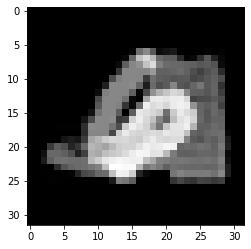

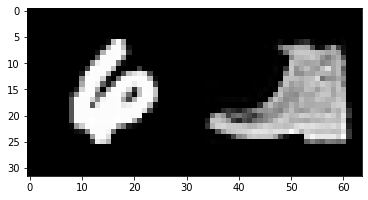

In [7]:
x, y = next(train_generator)
plt.imshow(x[0],cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y[0], cmap='gray', interpolation='nearest')
plt.show()

I've used the `display_prediction` function at the end of the notebook to show ten images predicted by my model compared to ten labels taken from the test set.

In [8]:
def display_prediction(array1, array2, s1, s2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(s1, s2))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(s1, s2))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

I've used the `display_MSE` function to show the trend of Mean Squared Error during training after fitting the model. The graph will show both the training set trend and the validation one.

In [9]:
def display_MSE(history):

    mse_training = history.history['mse']
    mse_val = history.history['val_mse']

    # Visualize the behavior of the MSE
    plt.plot(mse_training)
    plt.plot(mse_val)
    plt.grid()
    plt.title('MSE during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

The `build_BSS` function builds a model which has to solve a Blind Source Separation problem. To build the model, I've adopted a convolutional network. In particular, I've started from the implementation of the *u-net* model proposed in [this](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) paper.<br><br>
U-net was adopted in *biomedical image segmentation* with outstanding results. Its architecture consists of a number of different operations which follow a *downpath* where the input image feeds a sequence of **convolutions** and **maxpooling** operations, resulting in a spacial contraction. Each convolution is followed by a non-linear activation function (`relu`). It follows an *uppath* where an expansion is performed by a sequence of **up-convolutions** and **concatenations** with high-resolution features from contracting path to obtain a high resolution segmentation map.<br><br>
I've adapted this network to our problem by setting the number of channels to `n_ch=32` to speed up the computation and by incrementing the number of convolutions per layer which I've incremented to `conv_per_L=4` to extract more features. Moreover, I've added a `BatchNormalization()` layer after each convolution. This layer standardizes the input to the next layer for each mini-batch and optimizes the performances of the model.
<br><br>
Finally, in the last convolutional layer, I've set to 2 the dimensionality of the output space (i.e. the number of output filters in the convolution).<br>
`y = ks.layers.Conv2D(2, 1, activation='relu')(h)`
<br>By this way I've obtained two *32x32* feature maps that represents the two segmented objects (one from the `mnist` dataset and the other from the `fashion_mnist` one) which are reshaped in a *32x64* output coherent with the labels of the dataset.

In [10]:
def build_BSS(input_shape, n_ch=32, L=4, conv_per_L=4):
    x = ks.layers.Input(shape=input_shape)

    # DOWN
    backup_layers = []
    h = x
    for l in range(L):

        # Each level in the descent phase
        for c in range(conv_per_L):
            h = ks.layers.Conv2D(n_ch, 3, 1, padding='same')(h)
            h = ks.layers.ReLU()(h)
            h = ks.layers.BatchNormalization()(h)

        if l < L-1:
            # Downsample
            backup_layers.append(h) # save for the skip connection 
            h = ks.layers.MaxPool2D(padding='same')(h)

            # Update the channels
            n_ch = n_ch * 2
    
    # UP
    for l in range(L-1):
        # Reduce the channels
        n_ch = n_ch // 2

        # Upsample
        h = ks.layers.Conv2DTranspose(n_ch, 3, 2, padding='same')(h)

        # Concatenate
        h = ks.layers.concatenate([h, backup_layers.pop(-1)])

        # Each floor in the up phase
        for c in range(conv_per_L):
            h = ks.layers.Conv2D(n_ch, 3, 1, padding='same')(h)
            h = ks.layers.ReLU()(h)
            h = ks.layers.BatchNormalization()(h)
        
    # Output
    y = ks.layers.Conv2D(2, 1, activation='relu')(h)
    y = ks.layers.BatchNormalization()(y)
    y = layers.Reshape((32,64,1))(y) # output shape: (32,64,1)
    return ks.models.Model(x, y)

As a callback, I've instantiated the `ReduceRLOnPlateau` from tensorflow which reduces the learning rate when a metric (in my case, `val_mse`) has stopped improving so that the model can benefit from this reduction. With this callback, if no improvement is seen for a `patience` number of epochs, the learning rate is reduced.
I've set `min_lr=1e-6` because I've considered an exponential learning rate *10*$^{-7}$ to be too small as increasing step and `min_delta=1e-5` so that the minimum improvement of the validation MSE should be at least of exponential rate *10*$^{-5}$ since we're monitoring very small quantities.

In [11]:
reduce_lr = ReduceLROnPlateau(monitor='val_mse', factor=0.1, patience=4, min_lr=1e-6, verbose=1, mode='min', min_delta=1e-5)

Here, I've instantiated the model by choosing `Adam` optimizer and `mse` both as loss and as metric, since the metric was required in the trace. The I've printed out a summary of the model.

In [12]:
BSS_model = build_BSS(inputShape)
BSS_model.compile(optimizer=ks.optimizers.Adam(), loss='mse', metrics=['mse'])
print(BSS_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   320         ['input_1[0][0]']                
                                                                                                  
 re_lu (ReLU)                   (None, 32, 32, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32)  128         ['re_lu[0][0]']                  
 alization)                                                                                   

The model shows a total number of 4M parameters.

After compiling the model, I've fitted it.<br>
`train_generator` was passed as first argument, which contains both train samples and labels. The total number of learned samples by epoch will be calculated as <br>
$n=$ `steps_per_epoch` × `batchsize`
<br>
I've opted for a long run training of the model, so I've set a number of `steps_per_epoch=9500` ($n= 9500 \times 64 = 608000$). I've kept `validation_steps=350` so that the computation would have not required too much effort and time.<br>
As already mentioned, I've set `reduce_lr` as callback.

In [13]:
history = BSS_model.fit(train_generator,
                      batch_size=batchsize,
                      epochs=50,
                      validation_data=(validation_generator),
                      steps_per_epoch=9500,
                      validation_steps=350,
                      callbacks=[reduce_lr])

Epoch 1/50
9500/9500 [==============================] - 430s 44ms/step - loss: 0.0207 - mse: 0.0207 - val_loss: 0.0022 - val_mse: 0.0022 - lr: 0.0010
Epoch 2/50
9500/9500 [==============================] - 413s 43ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0013 - val_mse: 0.0013 - lr: 0.0010
Epoch 3/50
9500/9500 [==============================] - 412s 43ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0010 - val_mse: 0.0010 - lr: 0.0010
Epoch 4/50
9500/9500 [==============================] - 412s 43ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 9.5938e-04 - val_mse: 9.5938e-04 - lr: 0.0010
Epoch 5/50
9500/9500 [==============================] - 414s 44ms/step - loss: 9.7131e-04 - mse: 9.7131e-04 - val_loss: 8.4203e-04 - val_mse: 8.4203e-04 - lr: 0.0010
Epoch 6/50
9500/9500 [==============================] - 412s 43ms/step - loss: 9.0720e-04 - mse: 9.0720e-04 - val_loss: 7.9203e-04 - val_mse: 7.9203e-04 - lr: 0.0010
Epoch 7/50
9500/9500 [==============================] - 416s

From the output, we can notice that `mse` already improves between the first and the second epoch. At the fourth one, `val_mse` reaches an exponential rate 10$^{-4}$ . However, in the last five epochs it seems to 'oscillates' around 4.8$\times$10$^{-4}$, even if the learning rate has been decreased until reaching the minimum of 10$^{-6}$, so the learning would eventually stagnates in further epochs.

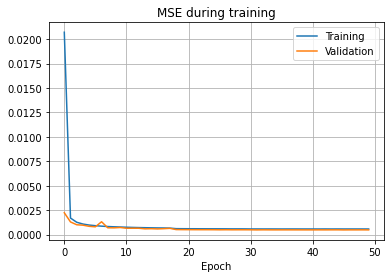

In [14]:
display_MSE(history)

As we can see in the diagram, the model does not overfit and the MSE computed over the validation is pretty much small which should anticipate that the model will obtain good results also in the evaluation on the test set.

We were asked to compute the evaluation over 20000 samples, so I've set the number of `steps=313` to obtain $313\times64=20032$ samples. As required, I've computed the evaluation over the test set for ten times and I've stored the results in the `results` list.

In [19]:
results = []

for i in range(0, 10):
  results.append(BSS_model.evaluate(test_generator, steps=313))

print(results)

313/313 [==============================] - 4s 14ms/step - loss: 5.0281e-04 - mse: 5.0281e-04
[[0.0005009039305150509, 0.0005009039305150509], [0.0005058324313722551, 0.0005058324313722551], [0.0005034383502788842, 0.0005034383502788842], [0.0004987141583114862, 0.0004987141583114862], [0.0005095007945783436, 0.0005095007945783436], [0.0005062773125246167, 0.0005062773125246167], [0.0005005557904951274, 0.0005005557904951274], [0.0005048310267738998, 0.0005048310267738998], [0.0005027797888033092, 0.0005027797888033092], [0.0005028125015087426, 0.0005028125015087426]]


Then, I've converted the list into a numpy array to compute the standard deviation over all the elements of the array with the `np.std` function of the NumPy library.

In [21]:
std = np.std(np.array(results))
print(std)

3.0033400121295935e-06


The result of `std` is very small as it was expected.

Finally, I've showed some outputs of the model with the `display_prediction` function that I mentioned at the beginning of the notebook.

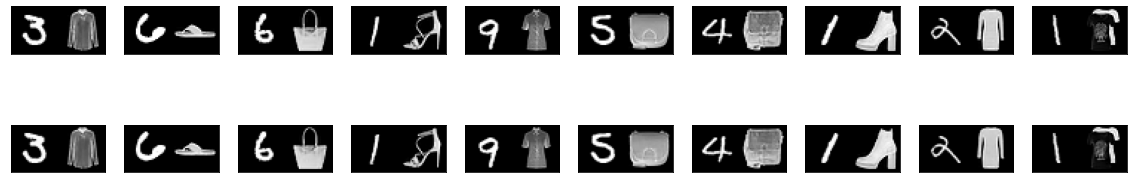

In [22]:
x_test, y_test = next(test_generator)
BSS_model_pred = BSS_model.predict(x_test)
np.delete(BSS_model_pred, 3, 1)
display_prediction(y_test, BSS_model_pred, 32, 64)

The first line shows the ground truth of ten elements of the test set while the second line shows the output predicted by the model. As we can see, the result is pretty much accurate except for some very small details of the clothes.

In [16]:
BSS_model.save_weights('BSS_model_weights.h5')

I've saved the weights as required and I've uploaded them [here](https://liveunibo-my.sharepoint.com/:u:/g/personal/simona_scala6_studio_unibo_it/EcIQm0UdcUlCraxtbkDiJ1UBWTyRDi14Pt2VLoZHgvXS-Q?e=gXQ2Ij) if they need to be checked.